# Auto-diff with JAX

JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

See:

- https://github.com/google/jax
- https://jax.readthedocs.io/en/latest/


In [1]:
# JAX's syntax is (for the most part) same as NumPy's!
# There is also a SciPy API support (jax.scipy)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# JAX's low level API
# (lax is just an anagram for XLA, not completely sure how they came up with name JAX)
from jax import lax


JAX's augmented numpy lives at `jax.numpy`. With a few exceptions, you can think of `jax.numpy` as directly interchangeable with `numpy`. As a general rule, you should use `jax.numpy` whenever you plan to use any of JAX's transformations.


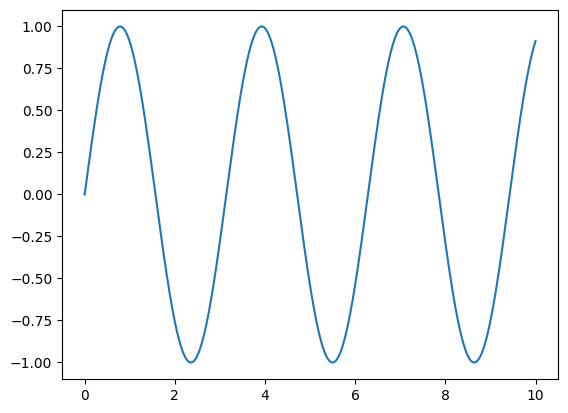

In [2]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [3]:
# Fact 2: JAX arrays are immutable!
size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [4]:
# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value  # ERROR!

[0 1 2 3 4 5 6 7 8 9]


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [5]:
# If this seems wasteful to you, it is indeed true (in normal settings).
# The thing is, if the input value x of x.at[idx].set(y) is not reused,
# you can tell JAX to optimize the array update to occur in-place.
# We will see the details after

jax_array = jnp.zeros((3, 3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array unchanged:\n", jax_array)
print("updated array:\n", updated_array)

# The expresiveness of NumPy is still there!

print("new array post-addition:")
new_jax_array = jax_array.at[::2, 1:].add(7.0)
print(new_jax_array)

original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
new array post-addition:
[[0. 7. 7.]
 [0. 0. 0.]
 [0. 7. 7.]]


In [6]:
# Fact 3: JAX handles random numbers differently (for the same reason arrays are immutable)
seed = 0
key = jax.random.PRNGKey(seed)

x = jax.random.normal(key, (10,))  # you need to explicitly pass the key i.e. PRNG state
print(type(x), x)  # notice the DeviceArray type - that leads us to the next cell!

<class 'jaxlib._jax.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


In [9]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!

size = 3000

# Data is automatically pushed to the AI accelerator (GPU, TPU)
x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

print("[1] GPU")
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
print("[2] Pure numpy (CPU)")
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
print("[3] GPU + data transfer")
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = jax.device_put(x_np)  # push NumPy explicitly to GPU
print("[4] GPU + explicit pre-data transfer (like [1] but explicit)")
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

[1] GPU
251 ms ± 3.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[2] Pure numpy (CPU)
168 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[3] GPU + data transfer
260 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[4] GPU + explicit pre-data transfer (like [1] but explicit)
253 ms ± 5.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## JAX transform functions

`jit` compiles your functions using XLA and caches them to reach the best speed


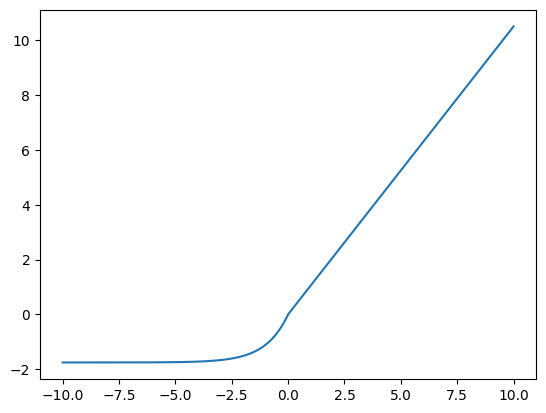

non-jit version:
1.1 ms ± 7.49 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jit version:
296 μs ± 479 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def visualize_fn(fn, l=-10, r=10, n=1000):
  x = np.linspace(l, r, num=n)
  y = fn(x)
  plt.plot(x, y); plt.show()

# Define a function
def selu(x, alpha=1.67, lmbda=1.05):  # note: SELU is an activation function
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jax.jit(selu)  # let's jit it

# Visualize SELU (just for your understanding, it's always a good idea to visualize stuff)
visualize_fn(selu)

# Benchmark non-jit vs jit version
data = jax.random.normal(key, (1000000,))

print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

## Automatic differentiation in JAX

JAX augments numpy and Python code with function transformations which make it trivial to perform operations common in machine learning programs.

The function `df = jax.grad(f, argnums = 0)` takes the callable object `f` and returns another callable object, `df`, evaluating the gradient of `f` w.r.t. the argument(s) of index(es) `argnums`. For more information, check out the [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=grad#jax.grad).


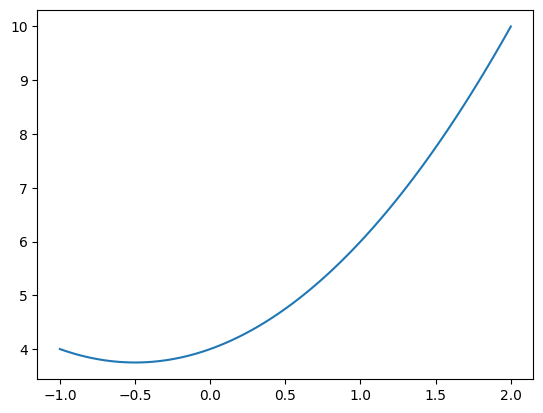

6.0 3.0 2.0 0.0


In [8]:
x = 1.0  # example input

f = lambda x: x**2 + x + 4  # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

dfdx = jax.grad(f)  # 2*x + 1
d2fdx = jax.grad(dfdx)  # 2
d3fdx = jax.grad(d2fdx)  # 0

print(f(x), dfdx(x), d2fdx(x), d3fdx(x))

### What if we had two inputs?

We use `jacrev` and `jacfwd`:

These two functions compute the same values (up to machine numerics), but differ in their implementation: `jacfwd` uses forward-mode automatic differentiation, which is more efficient for “tall” Jacobian matrices, while `jacrev` uses reverse-mode, which is more efficient for “wide” Jacobian matrices. For matrices that are near-square, `jacfwd` probably has an edge over `jacrev`.

To implement hessian, we could have used `jacfwd(jacrev(f))` or `jacrev(jacfwd(f))` or any other composition of the two. But forward-over-reverse is typically the most efficient. That’s because in the inner Jacobian computation we’re often differentiating a function wide Jacobian (maybe like a loss function $f: \mathbb{R}^n \to \mathbb{R}$), while in the outer Jacobian computation we’re differentiating a function with a square Jacobian (since $\nabla f: \mathbb{R}^n \to \mathbb{R}^n$), which is where forward-mode wins out.


In [9]:
f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]


def eval_hessian(f):
    return jax.jit(jax.jacfwd(jax.jacrev(f, argnums=(0, 1)), argnums=(0, 1)))


jacobian = jax.jacrev(f, argnums=(0, 1))(1.0, 1.0)
hessian = eval_hessian(f)(1.0, 1.0)
print(f"Jacobian = {np.asarray(jacobian)}")
print(f"Hessian = {np.asarray(hessian)}")

Jacobian = [2. 2.]
Hessian = [[2. 0.]
 [0. 2.]]


In [10]:
# Naturally, the function passed to grad can work with array inputs
f = lambda x: x[0] * x[0] + x[1] * x[1]


def eval_hessian(f):
    return jax.jit(jax.jacfwd(jax.jacrev(f)))


x0 = jnp.array([2.0, 1.0])
jacobian = jax.jacrev(f)(x0)
hessian = eval_hessian(f)(x0)
print(f"Jacobian = {np.asarray(jacobian)}")
print(f"Hessian = {np.asarray(hessian)}")

Jacobian = [4. 2.]
Hessian = [[2. 0.]
 [0. 2.]]


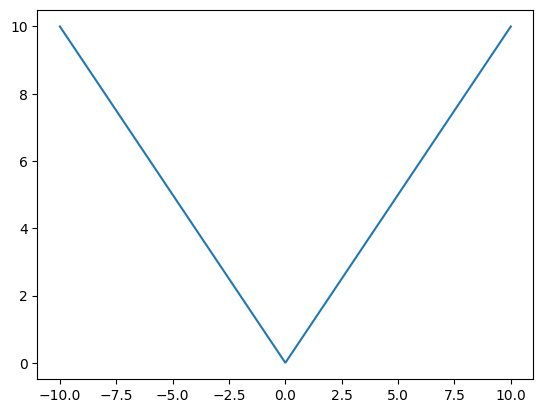

dfdx(0.0)   = 1.00000000000000000e+00
dfdx(+1e-5) = 1.00000000000000000e+00
dfdx(-1e-5) = -1.00000000000000000e+00


In [11]:
# Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

dfdx = jax.grad(f)
print(f"dfdx(0.0)   = {dfdx(0.0)  :.17e}")
print(f"dfdx(+1e-5) = {dfdx(+1e-5):.17e}")
print(f"dfdx(-1e-5) = {dfdx(-1e-5):.17e}")

## Vectorize functions with `vmap()`


In [36]:
def custom_dot(x, y):
    return jnp.dot(x, y) ** 2

def naive_custom_dot(x_batched, y_batched):
    return jnp.stack([
        custom_dot(v1, v2)
        for v1, v2 in zip(x_batched, y_batched)
    ])

@jax.jit
def jit_naive_custom_dot(x_batched, y_batched):
    return jnp.stack([
        custom_dot(v1, v2)
        for v1, v2 in zip(x_batched, y_batched)
    ])

batched_custom_dot = jax.vmap(custom_dot, in_axes=[0, 0])
jit_batched_custom_dot = jax.jit(jax.vmap(custom_dot, in_axes=[0, 0]))

x = jnp.asarray(np.random.rand(1000, 50))
y = jnp.asarray(np.random.rand(1000, 50))

print("Naive")
%timeit naive_custom_dot(x, y)
print("Vectorized")
%timeit batched_custom_dot(x, y)
print("JIT")
%timeit jit_naive_custom_dot(x, y)
print("Vectorized + JIT")
%timeit jit_batched_custom_dot(x, y)


Naive
78.7 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Vectorized
455 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
JIT
47.5 µs ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vectorized + JIT
27 µs ± 332 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## The nitty-gritty: JAX API structure


In [ ]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1.0, 1.0))  # works
print(lax.add(1, 1.0))  # ERROR! jax.lax API requires explicit type promotion

In [40]:
# Example 2: lax is more powerful (but as a tradeoff less user-friendly)

x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)],
)  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1e-6)

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]
[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


### Gotcha #1: The limitations of JIT

We have used boolean mask extensively, what happens if we use them in JAX?

In [ ]:
def get_negatives(x):
    return x[x < 0]


x = jax.random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))
print(jax.jit(get_negatives)(x))  # ERROR!

The issue comes from the fact that `x[x < 0]` returns an array whose size depends on the values within x; another way of saying this is that `x[x < 0]` has a dynamic shape. JAX's transform model does not currently support dynamically-shaped arrays, and the result is the error you see.


In [41]:
# So how does it work in the background? -> tracing on different levels of abstraction


@jax.jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result


x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))  # The first call has the overhead of compiling the function


x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second call:")
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[ 5.298445  13.789821   7.3990273]
Second call:
[ 1.84385   -0.1378496  2.1583145]


In [42]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)


print(jax.make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [63]:
# 2nd example of a failure:


@jax.jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x


f(1, True) # ERROR!

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at /tmp/ipykernel_386474/2687143603.py:4 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [36]:
# Workaround: the "static" arguments

from functools import partial


@partial(jax.jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x


print(f(1, True))
print(f(2, True))
# Here we do another jit compilation
print(f(2, False))
print(f(23, False))
# Here we do another jit compilation
print(f(44, 1))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-44


JAX is designed to work only on pure functions!

Pure function? Informal definition:

- All the input data is passed through the function parameters, all the results are output through the function results.
- A pure function will always return the same result if invoked with the same inputs.


In [44]:
# Example 3

g = 0.0


def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2


# JAX captures the value of the global during the first run
print("First call: ", jax.jit(impure_uses_globals)(4.0))

# Let's update the global!
g = 10.0

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jax.jit(impure_uses_globals)(5.0))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", jax.jit(impure_uses_globals)(jnp.array([4.0])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


### Gotcha #2: Out-of-Bounds Indexing

Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).


In [44]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


### Gotcha #3: random numbers


In [17]:
# NumPy - PRNG is stateful!
seed = 0

# Let's sample calling the same function twice
np.random.seed(seed)

rng_state = np.random.get_state()
print("numpy random state", rng_state[2:])

print("A random number", np.random.random())
rng_state = np.random.get_state()
print("numpy random state",rng_state[2:])

print("A random number", np.random.random())
rng_state = np.random.get_state()
print("numpy random state",rng_state[2:])

numpy random state (624, 0, 0.0)
A random number 0.5488135039273248
numpy random state (2, 0, 0.0)
A random number 0.7151893663724195
numpy random state (4, 0, 0.0)


In [16]:
# JAX's random functions can't modify PRNG's state!

key = jax.random.PRNGKey(seed)
print("JAX rng state", key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print("A random number", jax.random.normal(key, shape=(1,)))
print("JAX rng state",key)  # verify that the state hasn't changed

print("A random number", jax.random.normal(key, shape=(1,)))  # oops - same results?
print("JAX rng state",key)

JAX rng state [0 0]
A random number [-0.20584226]
JAX rng state [0 0]
A random number [-0.20584226]
JAX rng state [0 0]


In [18]:
# Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = jax.random.split(key, 2)
normal_pseudorandom = jax.random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

old key [0 0]
    \---SPLIT --> new key    [4146024105  967050713]
             \--> new subkey [2718843009 1272950319] --> normal [-1.2515389]


In [33]:
# Why this design?
# Well...think...with current design can the code be:
# 1) reproducible?
# 2) parallelizable?
# 3) vectorisable?

np.random.seed(seed)


def bar():
    return np.random.uniform()


def baz():
    return np.random.uniform()


# e.g. imagine bar and baz run on two different CPU/GPU (in a parallel env)
# than the result may be either [0.3 + 2*0.4] or [0.4 + 2*0.3]
# depending on how first calls the `np.random.uniform` between `bar` and `baz`
def foo():
    return bar() + 2 * baz()


print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

1.6997945441046411


### Gotcha #4: Control Flow


In [49]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3.0 * x**2
    else:
        return -4 * x


x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]

print(jax.grad(f)(2.0))  # ok!
print(jax.grad(f)(4.0))  # ok!

12.0
-4.0


In [53]:
# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations),
# but we require more constraints on the Python code to complete the trace."

# Solution (recall: we already have seen this)
f_jit = jax.jit(f, static_argnums=(0,))
x = 2.0

print(jax.make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

# WARNING: still for each x we have to jit a new function, this might be expensive!

{ lambda ; . let
    a:f32[] = pjit[jaxpr={ lambda ; . let  in (12.0,) } name=f] 
  in (a,) }
12.0


In [54]:
# Example 2: range depends on value again


def f(x, n):
    y = 0.0
    for i in range(n):
        y = y + x[i]
    return y


f_jit = jax.jit(f, static_argnums=(1,))
x = (jnp.array([2.0, 3.0, 4.0]), 15)

print(jax.make_jaxpr(f_jit, static_argnums=(1,))(*x))  # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

{ lambda ; a:f32[3]. let
    b:f32[] = pjit[
      jaxpr={ lambda ; c:f32[3]. let
          d:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] c
          e:f32[] = squeeze[dimensions=(0,)] d
          f:f32[] = add 0.0 e
          g:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] c
          h:f32[] = squeeze[dimensions=(0,)] g
          i:f32[] = add f h
          j:f32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] c
          k:f32[] = squeeze[dimensions=(0,)] j
          l:f32[] = add i k
          m:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 3
          n:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] c m
          o:f32[] = add l n
    

In [55]:
# Even "better" (it's less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i, val: val + x[i]
    return lax.fori_loop(0, n, body_fun, 0.0)


f_fori_jit = jax.jit(f_fori)

print(jax.make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = pjit[
      jaxpr={ lambda ; d:f32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:f32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
                n:i32[] = add m 3
                o:i32[] = select_n l h n
                p:f32[1] = dynamic_slice[slice_sizes=(1,)] g o
                q:f32[] = squeeze[dimensions=(0,)] p
                r:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] j
                s:f32[] = add r q
              in (k, i, s) }
            body_nconsts=1
            cond_jaxpr={ lambda ; t:i32[] u:i32[] v:f32[]. let
                w:bool[] = lt t u
              in (w,) }
            cond_nconsts=0
          ] d 0 e 0.0
        in (f,) }
      name=f_fori
    ] a b
  

In [60]:
# Example 3: this is not problematic (it'll only cache a single branch)


def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x


print(jax.make_jaxpr(log2_if_rank_2)(jnp.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


### Other gotchas


In [61]:
# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
jax.config.update("jax_debug_nans", False)  # Change this flag and re-run the cell
jnp.divide(0.0, 0.0)

Array(nan, dtype=float32, weak_type=True)

In [62]:
# JAX enforces single precision! There are simple ways around it though.
jax.config.update("jax_enable_x64", True)
x = jax.random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

float64
